# Chap14-2. 순환 신경망 (RNN, Recurrent Neural Network) - (2)

저번 포스팅인 [07-1. 순환 신경망 - (1)](http://excelsior-cjh.tistory.com/183)에서는 시계열 데이터에 적합한 모델인 RNN의 구조와 텐서플로(TensorFlow)의 `BasicRNNCell`과 `static_rnn()`, `dynamic_rnn()`을 이용해 RNN을 구현하는 방법에 대해 알아보았다. 이번 포스팅에서는 RNN을 학습시키는 방법과 심층 RNN에 대해 알아보도록 하자.

## 1. RNN 학습시키기

### 1.1 BPTT (BackPropagation Through Time)

RNN은 기존 신경망의 역전파(backprop)와는 달리 타임 스텝별로 네트워크를 펼친 다음, 역전파 알고리즘을 사용하는데 이를 **BPTT**(BackPropagation Through Time)라고 한다. 

![BPTT](./images/bptt01.png)

BPTT 또한 일반적인 역전파와 같이 먼저 순전파(forward prop)로 각 타임 스텝별 시퀀스를 출력한다. 그런다음 이 출력 시퀀스와 손실(비용)함수를 사용하여 각 타임 스텝별 Loss를 구한다. 그리고 손실 함수의 그래디언트는 위의 그림과 같이 펼쳐진 네트워크를 따라 역방향으로 전파된다. BPTT는 그래디언트가 마지막 타임 스텝인 출력뿐만 아니라 손실함수를 사용한 모든 출력에서 역방향으로 전파된다.  

RNN은 각 타임 스텝마다 같은 매개변수 $\mathbf{W}$ 와 $\mathbf{b}$ 이 사용되기 때문에 역전파가 진행되면서 모든 타임 스텝에 걸쳐 매개변수 값이 합산된다. 이렇게 업데이트된 가중치는 순전파 동안에는 모든 타임 스텝에 동일한 가중치가 적용된다.

### 1.2 Truncated BPTT

3.1에서 살펴본 BPTT는 전체의 타임 스텝마다 처음부터 끝까지 역전파를 하기 때문에 타임 스텝이 클 수록 계산량이 많아지는 문제가 있다. 이러한 계산량 문제를 해결하기 위해 전체 타임 스텝을 일정 구간(예를들어 3 또는 5 구간)으로 나눠 역전파를 하는 **Truncated BPTT**를 사용한다. 



![truncated-bptt](./images/bptt02.png)

### 1.3 RNN을 이용한 분류기 구현

 이번에는 RNN을 이용해 MNIST 숫자 이미지 데이터셋을 분류하는 분류기를 구현해보자. MNIST와 같은 이미지 데이터는 이전 포스팅 [06. 합성곱 신경망](http://excelsior-cjh.tistory.com/180)에서 살펴본 이미지의 공간(spatial) 구조를 활용하는 CNN 모델이 더 적합하지만, 인접한 영역의 픽셀은 서로 연관되어 있으므로 이를 시퀀스 데이터로 볼 수도 있다.   아래의 그림처럼 MNIST 데이터에서 `28 x 28` 픽셀을 시퀀스의 각원소는 `28`개의 픽셀을 가진 길이가 `28` 시퀀스 데이터로 볼 수 있다.

![](./images/mnist_seq.png)



아래의 코드는 텐서플로(TensorFlow)의 `BasicRNNCell`과 `dynamic_rnn()`을 이용해 MNIST 분류기를 구현한 코드이다.

### Set Up

In [1]:
import os
import numpy as np
import tensorflow as tf

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

#### 1.3.1 MNIST Data Load

In [3]:
################
# Layer Params #
################
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
train_x = train_x.astype(np.float32).reshape(-1, 28*28) / 255.0  # (784,)
test_x = test_x.astype(np.float32).reshape(-1, 28*28) / 255.0
train_y = train_y.astype(np.int32)
test_y = test_y.astype(np.int32)
valid_x, train_x = train_x[:5000], train_x[5000:]
valid_y, train_y = train_y[:5000], train_y[5000:]
test_x = test_x.reshape([-1, n_steps, n_inputs])
valid_x = valid_x.reshape([-1, n_steps, n_inputs])

print('train_x.shape :', train_x.shape)
print('valid_x.shape :', valid_x.shape)
print('test_x.shape :', test_x.shape)

train_x.shape : (55000, 784)
valid_x.shape : (5000, 28, 28)
test_x.shape : (10000, 28, 28)


#### 1.3.2 RNN for MNIST

그런 다음, 아래의 코드와 같이 MNIST 데이터셋을 분류하는 RNN 모델을 만들어 준다. MNIST를 분류하는 RNN 모델은 아래의 그림과 같이 RNN모델 중 28개의 타임 스텝(28 pixels)의 시퀀스를 입력받아 하나의 벡터를 출력하는 Sequence-to-Vector 모델이다.

![](./images/rnn-mnist.PNG)

In [9]:
# Mini-batch
def shuffle_batch(features, labels, batch_size):
    rnd_idx = np.random.permutation(len(features))
    n_batches = len(features) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        batch_x, batch_y = features[batch_idx], labels[batch_idx]
        yield batch_x, batch_y

In [13]:
reset_graph()

inputs = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
labels = tf.placeholder(tf.int32, [None])

# RNN Model
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, inputs, dtype=tf.float32)
# dense layer
logits = tf.layers.dense(states, n_outputs)  # states = outputs[-1]

# loss
xentropy = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))

################
# Train Params #
################
learning_rate = 0.001
n_epochs = 5
batch_size = 150

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(xentropy)

# metric
correct = tf.nn.in_top_k(logits, labels, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [14]:
# Train
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for batch_x, batch_y in shuffle_batch(train_x, train_y, batch_size):
            batch_x = batch_x.reshape([-1, n_steps, n_inputs])
            sess.run(train_op, 
                     feed_dict={inputs: batch_x, labels: batch_y})
        acc_batch = accuracy.eval(feed_dict={inputs: batch_x, labels: batch_y})
        acc_valid = accuracy.eval(feed_dict={inputs: valid_x, labels: valid_y})
        loss_batch = xentropy.eval(feed_dict={inputs: batch_x, labels: batch_y})
        print('epoch : {:03d}'.format(epoch),
              'acc_batch : {:.4f}, acc_valid : {:.4f}'.format(acc_batch, acc_valid),
              'loss_batch : {:.4f}'.format(loss_batch))

epoch : 000 acc_batch : 0.9533, acc_valid : 0.9322 loss_batch : 0.1928
epoch : 001 acc_batch : 0.9600, acc_valid : 0.9530 loss_batch : 0.1873
epoch : 002 acc_batch : 0.9600, acc_valid : 0.9520 loss_batch : 0.2149
epoch : 003 acc_batch : 0.9600, acc_valid : 0.9606 loss_batch : 0.1332
epoch : 004 acc_batch : 0.9800, acc_valid : 0.9730 loss_batch : 0.0784


### 1.4 RNN을 이용한 시계열 데이터 예측

이번에는 주식가격과 같은 시계열(time series) 데이터를 예측하는 RNN 모델을 구현해 보도록 하자.

#### 1.4.1 가상의 시계열 데이터 만들기

RNN 모델에 사용하기 위한 가상의 시계열 데이터를 다음과 같이 만들어 준다.

In [15]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

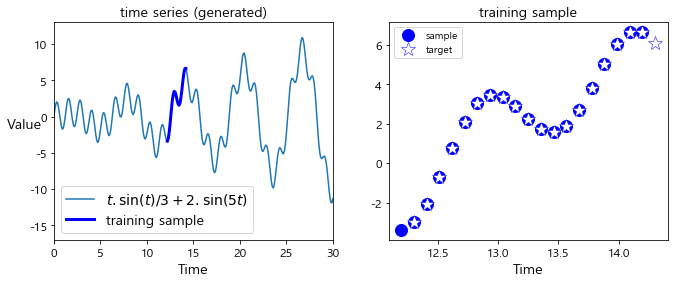

In [16]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="training sample")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value", rotation=0)

plt.subplot(122)
plt.title("training sample", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=12, label="sample")
plt.plot(t_instance[1:], time_series(t_instance[1:]), 
         "w*", markeredgewidth=0.5, markeredgecolor="b", markersize=14, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

#### 1.4.2 RNN for Time Series

이제 시계열 데이터를 예측하는 RNN을 모델링 해보자. 100개의 순환뉴런을 가지고, 입력 시퀀스의 길이가 20이므로 20개의 타임 스텝을 가지며, 출력 시퀀스 또한 길이가 20인 시퀀스를 출력한다. RNN의 출력결과는 아래의 그림과 같이 [미니배치, 뉴런 개수] (`[batch_size, n_neurons]`)이기 때문에, 미니 배치를 50으로 할 경우, `(50, 100)`의 형태를 가지는 출력 벡터가 나오게 된다. 하지만, 실제로 우리가 원하는 출력은 각 타임 스텝 마다 하나의 출력, 즉 `(batch_size, 1)`의 형태를 원하기 때문에 아래의 그림과 같이 다음의 과정이 필요하다.

1.  각 타임 스텝마다 `(batch_size, n_neurons)` 출력 벡터를 `tf.reshape()`을 이용해 쌓는다(stack).
2. 그런 다음, 1개의 유닛을 가지는 Fully-Connected Layer를 적용한다. 이때의 FC Layer는 단지 차원 축소를 위한 레이어이기 때문에 활성화 함수를 사용하지 않는다.
3. 마지막으로, `tf.reshape()`을 이용해 차원 축소시킨 출력을 다시 타임 스텝별로 풀어준다(unstack).

![](./images/time-series02.PNG)



아래의 코드는 위의 과정을 적용하여 시계열 데이터를 예측하는 RNN 모델을 구현한 코드이다. 

In [10]:
reset_graph()

################
# Layer Params #
################
n_steps = 20
n_neurons = 100
n_inputs = 1
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

# RNN Model
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

# 하나의 출력을 위한 작업
stacked_rnn_outputs = tf.reshape(tensor=rnn_outputs, shape=[-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
predictions = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

################
# Train Params #
################
learning_rate = 0.001
n_iterations = 600
batch_size = 50

# loss
mse = tf.losses.mean_squared_error(labels=y, predictions=predictions)
# optimizer
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mse)

In [11]:
# Train
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for iteration in range(n_iterations):
        batch_x, batch_y = next_batch(batch_size, n_steps)
        sess.run(train_op, feed_dict={X: batch_x, y: batch_y})
        if iteration % 100 == 0:
            loss = mse.eval(feed_dict={X: batch_x, y: batch_y})
            print('step: {:03d}, MSE: {:.4f}'.format(iteration, loss))
            
    # 새로운 데이터 예측하기
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(predictions, feed_dict={X: X_new})
    
print('y_pred:{}\n{}'.format(y_pred.shape, y_pred))

step: 000, MSE: 13.9070
step: 100, MSE: 0.5057
step: 200, MSE: 0.1974
step: 300, MSE: 0.1012
step: 400, MSE: 0.0685
step: 500, MSE: 0.0629
y_pred:(1, 20, 1)
[[[-3.5476217]
  [-2.5151467]
  [-1.1526244]
  [ 0.5834651]
  [ 2.015859 ]
  [ 3.030329 ]
  [ 3.5977817]
  [ 3.4671748]
  [ 2.7913451]
  [ 2.1190128]
  [ 1.6537794]
  [ 1.5421822]
  [ 1.940395 ]
  [ 2.7001028]
  [ 3.8418205]
  [ 5.09896  ]
  [ 6.124487 ]
  [ 6.6779537]
  [ 6.6244407]
  [ 6.0005555]]]


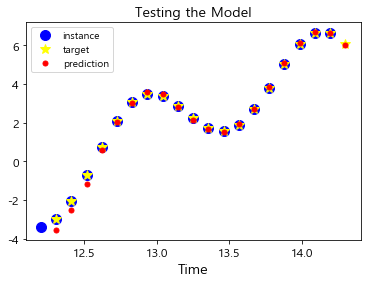

In [17]:
plt.title("Testing the Model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target", color='yellow')
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

#### 1.4.3 OutputProjectionWrapper를 사용한 RNN 모델링

1.4.2에서는 RNN의 출력결과를 우리가 원하는 형태로 맞춰주기 위해 *stack → FC layer → unstack*과정이 필요했다.  텐서플로에서는 [`tf.contrib.rnn.OutputProjectionWrapper`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/OutputProjectionWrapper) 를 이용해 Cell을 감싸서 아래의 그림과 같은 역할을 해준다.  `OutputProjectionWrapper`의 FC Layer는 출력 시퀀스(outputs)에만 적용되고 state($h_t$)에는 적용되지 않는다.

![](./images/time-series04.PNG)



아래의 코드는 `OutputProjectionWrapper`를 이용해 1.4.2의 동일한 예제를 작성한 코드이다.

In [18]:
reset_graph()

################
# Layer Params #
################
n_steps = 20
n_neurons = 100
n_inputs = 1
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

# RNN Model using OutputProjectionWrapper
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
predictions, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

################
# Train Params #
################
learning_rate = 0.001
n_iterations = 600
batch_size = 50

# loss
mse = tf.losses.mean_squared_error(labels=y, predictions=predictions)
# optimizer
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mse)

In [19]:
# Train
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for iteration in range(n_iterations):
        batch_x, batch_y = next_batch(batch_size, n_steps)
        sess.run(train_op, feed_dict={X: batch_x, y: batch_y})
        if iteration % 100 == 0:
            loss = mse.eval(feed_dict={X: batch_x, y: batch_y})
            print('step: {:03d}, MSE: {:.4f}'.format(iteration, loss))
            
    # 새로운 데이터 예측하기
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(predictions, feed_dict={X: X_new})
    
print('y_pred:{}\n{}'.format(y_pred.shape, y_pred))

step: 000, MSE: 11.9673
step: 100, MSE: 0.5258
step: 200, MSE: 0.1496
step: 300, MSE: 0.0728
step: 400, MSE: 0.0616
step: 500, MSE: 0.0594
y_pred:(1, 20, 1)
[[[-3.5285556 ]
  [-2.4768994 ]
  [-1.1221677 ]
  [ 0.59313875]
  [ 2.119323  ]
  [ 3.1693287 ]
  [ 3.457877  ]
  [ 3.2451653 ]
  [ 2.8801768 ]
  [ 2.2912362 ]
  [ 1.7846028 ]
  [ 1.4566743 ]
  [ 1.8437719 ]
  [ 2.712548  ]
  [ 3.904094  ]
  [ 5.13178   ]
  [ 6.1285706 ]
  [ 6.707691  ]
  [ 6.6761217 ]
  [ 6.0609703 ]]]


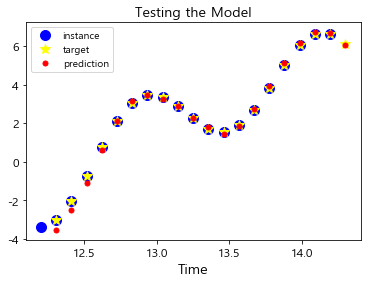

In [22]:
plt.title("Testing the Model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target", color='yellow')
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## 2. 심층 RNN

심층 RNN(deep RNN)은 아래의 그림처럼 RNN Cell을 여러 층으로 쌓은 것을 말한다. 일반적으로 딥러닝에서는 이러한 Deep RNN 모델이 많이 사용된다. 

![deep-rnn](./images/deep-rnn.PNG)

### 2.1 텐서플로에서의 Deep RNN

텐서플로에서는 [`tf.nn.rnn_cell.MultiRNNCell`](https://www.tensorflow.org/api_docs/python/tf/nn/rnn_cell/MultiRNNCell)을 이용해 RNN Cell을 여러층으로 쌓을 수 있는데 먼저 `BasicRNNCell`을 이용해 여러개의 Cell을 만들고, 이것을 `MultiRNNCell`로 쌓아서 deep RNN을 구현할 수 있다.  아래의 예제는 deep RNN을 구현한 간단한 예제 코드이다.

In [9]:
reset_graph()

################
# layer params #
################
n_inputs = 2
n_steps = 5
n_neurons = 100
n_layers = 3

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

# Deep RNN
layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

# Sample data
batch_x = np.random.rand(2, n_steps, n_inputs)  # shape: (2, 5, 2)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: batch_x})
    
print('outputs_val:{}'.format(outputs_val.shape))

outputs_val:(2, 5, 100)


### 2.2 Dropout 적용하기

2.1에서처럼 여러 층의 RNN Cell을 쌓게되면 오버피팅(overfitting)되기 쉽기 때문에 RNN layer의 전과 후에 드롭아웃(dropout) layer를 추가할 수 있다. 또한, RNN 층(layer) 사이에도 드롭아웃을 적용할 수 있는데, 텐서플로에서는 [`tf.nn.rnn_cell.DropoutWrapper`](https://www.tensorflow.org/api_docs/python/tf/nn/rnn_cell/DropoutWrapper)를 이용해 RNN 층 사이에도 드롭아웃을 적용할 수 있다.  아래의 예제는 `DropoutWrapper`를 이용해 RNN 층에 드롭아웃을 적용한 예제이다. 아래의 코드에서 사용한 데이터는 1.4.1에서 생성한 가상의 시계열 데이터를 사용했다.

In [33]:
reset_graph()

################
# layer params #
################
n_inputs = 1
n_outputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

# without dropout rate
keep_prob = tf.placeholder_with_default(1.0, shape=())
cells = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.nn.rnn_cell.DropoutWrapper(
                    cell, input_keep_prob=keep_prob,
                    state_keep_prob=keep_prob) for cell in cells]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

# 하나의 출력을 위한 작업
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
predictions = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

# loss
mse = tf.losses.mean_squared_error(labels=y, predictions=predictions)

################
# Train Params #
################
learning_rate = 0.01
train_keep_prob = 0.3
n_iterations = 1500
batch_size = 50

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mse)

In [34]:
# Train
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for iteration in range(n_iterations):
        batch_x, batch_y = next_batch(batch_size, n_steps)
        sess.run(train_op, feed_dict={X: batch_x, y: batch_y,
                                      keep_prob: train_keep_prob})
        if iteration % 300 == 0:
            loss = mse.eval(feed_dict={X: batch_x, y: batch_y})
            print('step: {:03d}, MSE: {:.4f}'.format(iteration, loss))
            
    # 새로운 데이터 예측하기
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(predictions, feed_dict={X: X_new})

step: 000, MSE: 4.1924
step: 300, MSE: 10.9267
step: 600, MSE: 12.2163
step: 900, MSE: 14.6663
step: 1200, MSE: 14.5340


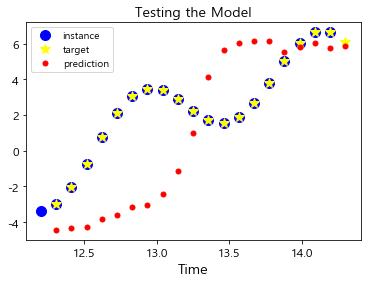

In [35]:
plt.title("Testing the Model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target", color='yellow')
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## 3. 마무리

이번 포스팅에서는 RNN을 학습시키는 방법인 BPTT와 텐서플로를 이용해 MNIST 분류기와 시계열 데이터를 예측하는 RNN 모델을 구현해 보았다. 그리고 심층 RNN을 구현하는 방법과 RNN에 드롭아웃을 적용하는 방법에 대해 알아보았다.

다음 포스팅에서는 타임스텝이 매우 긴 RNN의 학습단계에서의 문제점과 이를 보완한 RNN의 변형인 LSTM과 GRU에 대해 알아보도록 하자. 